# Diabeties Prediction Models

In this notebook I  put together four diabeties detection algorithm, the first is a logistic regression, the second a decision tree, third a deep learning model and lastly a random forest model. The dataset can be found here (https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset)

## Dependencies  

In [1]:
# Data handling
import pandas as pd 
# Linear algebra
import numpy as np
# Plots
import matplotlib.pyplot as plt 
import seaborn as sns
# Statistics
from scipy import stats
# Data preprocessing
from sklearn import preprocessing, svm 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import torch
from sklearn.ensemble import RandomForestClassifier 
import statsmodels.api as sm
# Evaluation 
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import Counter

## Bringing in the data

In [2]:
# Bringing the data into pandas so we can begin our analysis.

df = pd.read_csv('diabetes_prediction_dataset.csv')

In [3]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


As we can see there is this anonymized data that includes the 28 felids that represent some data about the transactions, an amount and a classification of fraud or not fraud. 

In [4]:
# To see the datatypes of our dataframe.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


## Visualization

The next stage is some data visualization, here I will go ahead and plot some of our data categories against our target variable which is diabetes. First the numerical features.

Text(0.5, 1.0, 'Age vs Diabetes')

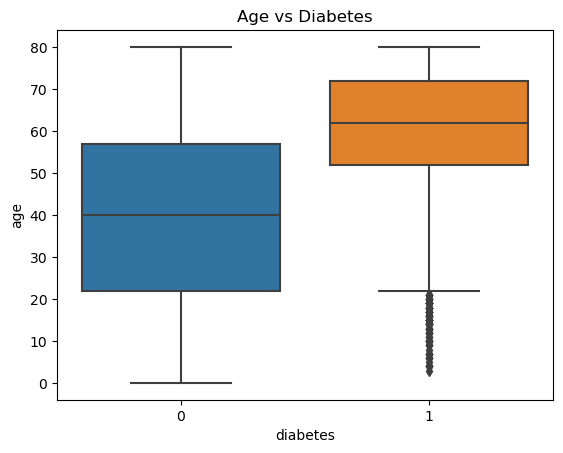

In [5]:
ax = sns.boxplot(data = df , x= 'diabetes', y = 'age')
plt.title('Age vs Diabetes')

Text(0.5, 1.0, 'Bmi vs Diabetes')

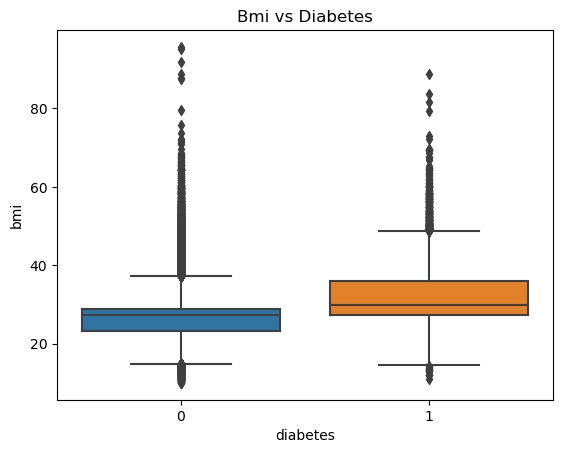

In [6]:
ax = sns.boxplot(data = df , x= 'diabetes', y = 'bmi')
plt.title('Bmi vs Diabetes')

Text(0.5, 1.0, 'HbA1c_level vs Diabetes')

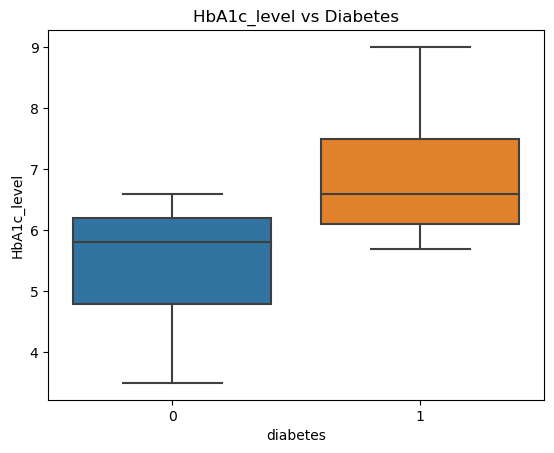

In [7]:
ax = sns.boxplot(data = df , x= 'diabetes', y = 'HbA1c_level')
plt.title('HbA1c_level vs Diabetes')

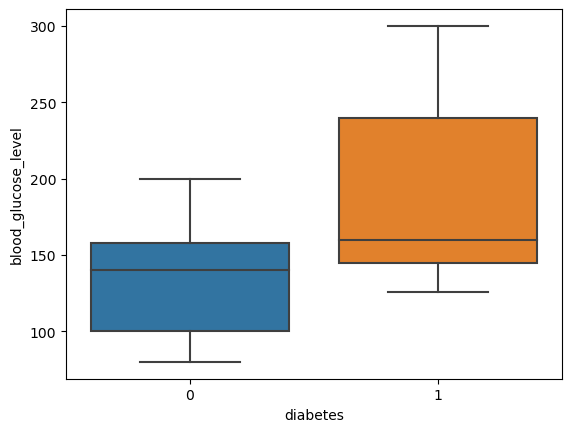

In [8]:
ax = sns.boxplot(data = df , x= 'diabetes', y = 'blood_glucose_level')

In [9]:
print(stats.pearsonr(df['HbA1c_level'], df['blood_glucose_level']))

PearsonRResult(statistic=0.16673292982896232, pvalue=0.0)


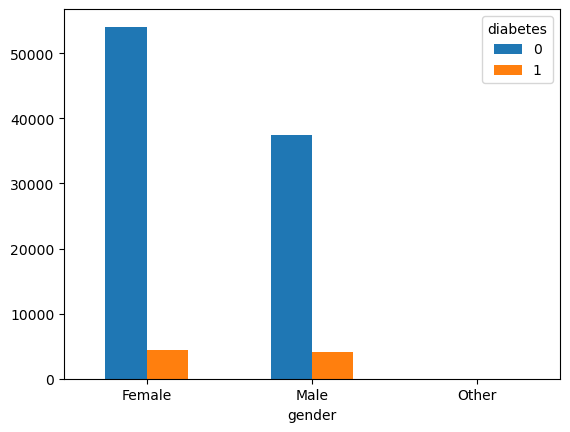

In [10]:
crosstb = pd.crosstab(df.gender, df.diabetes)
barplot = crosstb.plot.bar(rot=0)

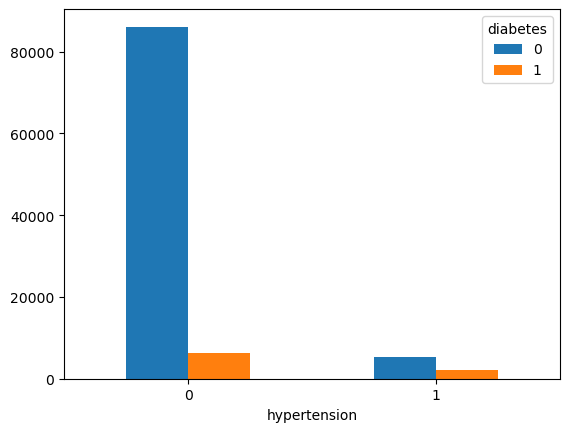

In [11]:
crosstb = pd.crosstab(df.hypertension, df.diabetes)
barplot = crosstb.plot.bar(rot=0)

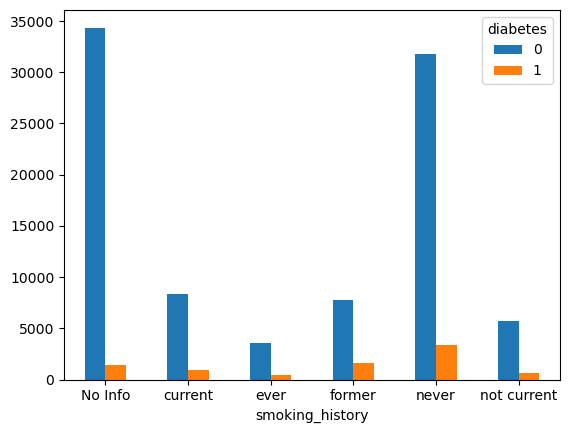

In [12]:
crosstb = pd.crosstab(df.smoking_history, df.diabetes)
barplot = crosstb.plot.bar(rot=0)

## Processing the data for analysis

As we can see it is mix of categorical data and numeric data, with a classification column at the end. The first process will be turning this data into numeric data where it has not already been transformed. In particular the smoking status and the gender catagories. Starting with the more complicated smoking category.

In [13]:
# The next thing that we need to do is transform the Smoking history column. First lets see what is in that column.

df.smoking_history.value_counts()

No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: smoking_history, dtype: int64

There are 6 Catagories of smoker here, including one where there is no information, but also the 'ever' category, which I would suspect is a typo and needs to be corrected to 'never'. we also need to combine the former and not current categories which we will do in a similar manor. 

In [14]:
df['smoking_history'] = df['smoking_history'].apply(lambda x: 'never' if x == 'ever' else x)
df['smoking_history'] = df['smoking_history'].apply(lambda x: 'former' if x == 'not current' else x)


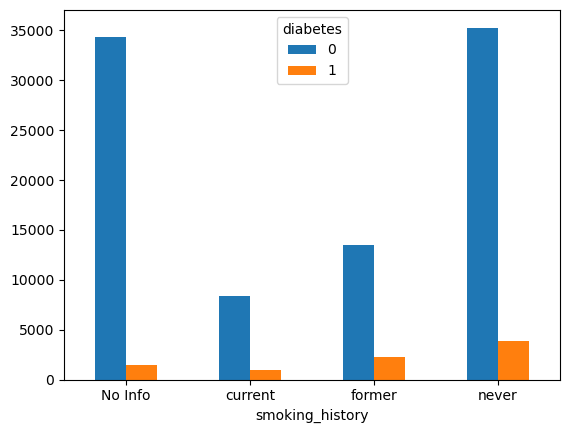

In [15]:
crosstb = pd.crosstab(df.smoking_history, df.diabetes)
barplot = crosstb.plot.bar(rot=0)

As we can see in the next cell the ever category is no longer present. 

In [16]:
df.smoking_history.value_counts()

never      39099
No Info    35816
former     15799
current     9286
Name: smoking_history, dtype: int64

Now something has to be done about the 'No info' category. my current inclination is to assign it an interpolated value that would be the same as former smoker in this instance.

In [17]:
df['smoking_history'] = df['smoking_history'].apply(lambda x: 'former' if x == 'No Info' else x)


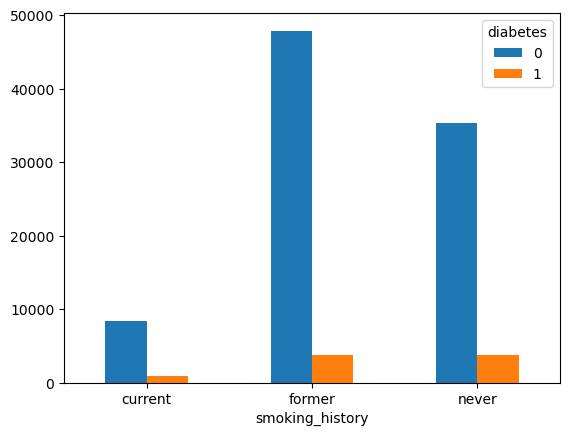

In [18]:
df.smoking_history.value_counts()
crosstb = pd.crosstab(df.smoking_history, df.diabetes)
barplot = crosstb.plot.bar(rot=0)

Now this information needs to be transformed into numerically represented categorical data, there are multiple ways that I could do this, the first would be to assign a value of 0.5 to previous smokers and no info, 1 to current smokers and 0 to never smoked. I am making the assumption here that being a former smoker will increase the chances of having diabetes more than never having smoked all together i.e. that it is in some way "in between" being a smoker and having never smoked. I did work out the conditional probabilities for each of the categories of smokers to see if this is confirmed by the data and it was not, however, I don't think this is sufficient evidence to rule out my assumption as the data is not sampled independently. I will go with this approach because the other solution to have 'smoked in the past' and 'smoked currently' would have some colinearity and may hurt the accuracy of the regression models. Notably though, assigning former to 0.5 is a non-linear transformation, we don't know that the effect is 50% of the currently smoking effect, for that reason, it will hurt non-linear models. 


In [19]:
df['smoking_history'] = df['smoking_history'].apply(lambda x: 0 if x == 'never' else x)
df['smoking_history'] = df['smoking_history'].apply(lambda x: 0.5 if x == 'former' else x)
df['smoking_history'] = df['smoking_history'].apply(lambda x: 1 if x == 'current' else x)

The next column that I need to change to categorical is the 'Gender' category, as such I will be assigning '1' to female and '0' to male.




In [20]:
df.gender.value_counts()

Female    58552
Male      41430
Other        18
Name: gender, dtype: int64

As we can see below there are 18 candidates who fall into the other category, given that the size of the dataset is 100000, it is ok to remove them from out analysis, not something that I could do with the not insignificant 'No info' category for smoking history. This does show that there is need for more anaysis of likelyhood of diabeties in people who do ot fall under 'male' or 'female' but remains outside the scope of this project. 

In [21]:
df = df[df.gender != 'Other']
df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Female' else 0)

df.gender.value_counts()

1    58552
0    41430
Name: gender, dtype: int64

In [22]:
# Separating the feature set from the target variable

feature_set = df.drop('diabetes', axis=1)
target_set = df['diabetes']

In [23]:
# To do our train test split of the data.

X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set, test_size= 0.20, random_state= 42)


In [24]:
# This dictionary will be used later to label the confusion matrices

class_names = {0:'Diabetes', 1:'Not_Diabetes'}

## Logistic Regression

In [25]:
# Notice here how I have increased the maximum number of iterations from the usual 100, given the number of features and the size of the dataset more than the standard is needed

logistic_regression_model = LogisticRegression(max_iter=1000)

logistic_regression_model.fit(X_train, y_train.values.ravel())

LogisticRegression(max_iter=1000)

In [26]:
# Running our test data through the model

predictions = logistic_regression_model.predict(X_test)


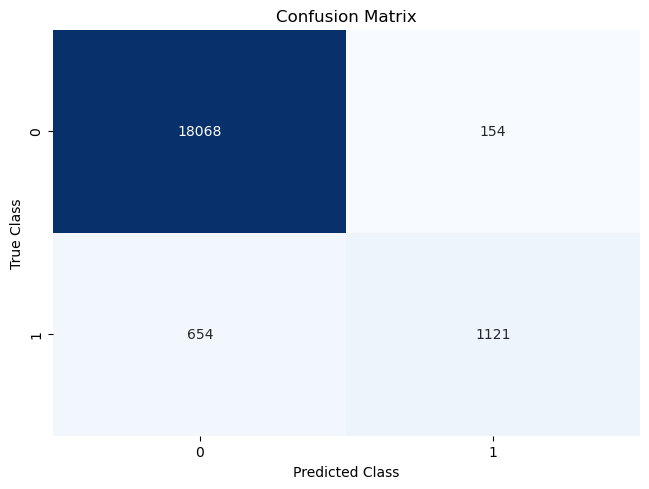

In [27]:
matrix = confusion_matrix(y_test, predictions)

dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [28]:
log_reg = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.287654
         Iterations 7


In [29]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:               diabetes   No. Observations:                79985
Model:                          Logit   Df Residuals:                    79977
Method:                           MLE   Df Model:                            7
Date:                Fri, 23 Jun 2023   Pseudo R-squ.:                0.003342
Time:                        01:07:42   Log-Likelihood:                -23008.
converged:                       True   LL-Null:                       -23085.
Covariance Type:            nonrobust   LLR p-value:                 5.119e-30
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
gender                 -0.8824      0.025    -35.634      0.000      -0.931      -0.834
age                     0.0166      0.001     27.134      0.000       0.015       0.018
hypertension    

To evaluate the model above we are going to consider the precision and the recall. 

The precision is important because we want to know what our ratio of true positives are to total positives are. This tells use how often are we getting the wrong person. For diabetes detection this measure of how much time the algorithm will waste by investigating false posatives. Massive over diagnosis is a problem, however in the case of a life altering illness that has a treatment proticol it is probably better that more people are tested if they are likely to have diabetes. 

The recall is important because it tells us how many of the target category the model "missed". The ideal score is closer to 1. Again this is an important metric as it tells us how many people could go without detection, important because going without treatment can result in serious complications.


In [30]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18222
           1       0.88      0.63      0.74      1775

    accuracy                           0.96     19997
   macro avg       0.92      0.81      0.86     19997
weighted avg       0.96      0.96      0.96     19997



## Decision Tree

In [31]:
# Calling the decision tree classifier from SK learn 

clf = DecisionTreeClassifier()

In [32]:
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

In [33]:
#Predict the response for test dataset
y_pred = clf.predict(X_test)

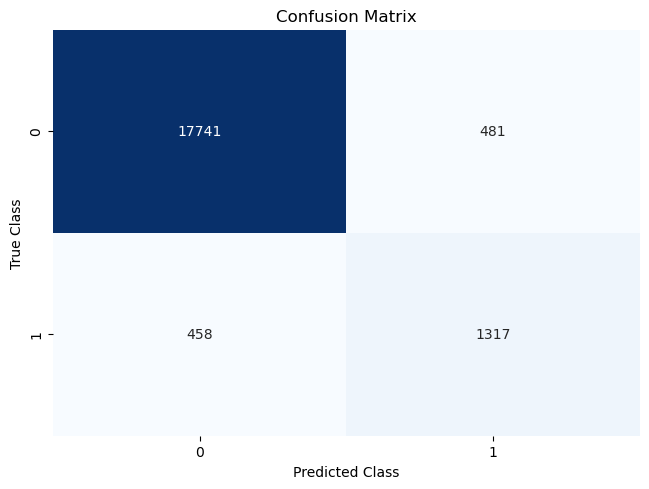

In [34]:
matrix = confusion_matrix(y_test, y_pred)

dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [35]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     18222
           1       0.73      0.74      0.74      1775

    accuracy                           0.95     19997
   macro avg       0.85      0.86      0.86     19997
weighted avg       0.95      0.95      0.95     19997



As we can see the decision tree outperforms the logistic regression on the same data, on both precision and recall.

## Deep learning

In [36]:
# The first thing that we need to do is to scale the data so we don't end up with gradient explosion issues. 


# Original dataset
x = feature_set.values
y = target_set.values
scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.transform(x)
X_train1, X_test1, y_train1, y_test1 = train_test_split(x, y, test_size=0.2, random_state=42)

print('Sampled train dataset shape %s' % Counter(y_train1))
print('Sampled validation dataset shape %s' % Counter(y_test1))

Sampled train dataset shape Counter({0: 73260, 1: 6725})
Sampled validation dataset shape Counter({0: 18222, 1: 1775})


In [37]:
# time to bring it into pytorch and the torch dataloaders
batch_size = 512

numeber_of_cores = 0

training_dataset =  torch.utils.data.TensorDataset(torch.tensor(X_train1).float(), torch.tensor(y_train1).float())
test_dataset =      torch.utils.data.TensorDataset(torch.tensor(X_test1).float(), torch.tensor(y_test1).float())

train_dataloader = torch.utils.data.DataLoader(training_dataset,batch_size=batch_size, num_workers = numeber_of_cores)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, num_workers = numeber_of_cores)

In [38]:
# Creating the neural network class defining a two layer model that has ReLu layers between

class Classifier(torch.nn.Module):
    def __init__(self,n_input =10 , n_hidden = 15, n_output = 4, drop_prob = 0.5):
        super().__init__()
        # The first hidden layer
        self.extractor1 = torch.nn.Linear(n_input, n_hidden)
        # Second hidden layer
        self.extractor2 = torch.nn.Linear(n_hidden, n_hidden)
        # Third hidden layer
        self.extractor3 = torch.nn.Linear(n_hidden, n_hidden)
        # Relu non linear layer
        self.relu = torch.nn.ReLU()
        # A drop out for better learning
        self.dropout = torch.nn.Dropout(drop_prob)
        # The final layer that will pass out the classification
        self.classifier = torch.nn.Linear(n_hidden,n_output)
    # Forward pass of the data, taking it and   
    def forward(self, x_batch):
        x = self.relu(self.extractor1(x_batch))
        x = self.relu(self.extractor2(x))
        x = self.relu(self.extractor3(x))
        x = self.dropout(x)
        return self.classifier(x).squeeze()

In [39]:
def loss(model, loss_function, x_batch , y_batch, opt = None):
        # Using the loss function of choise to calculate the loss on each step
    loss = loss_function(model(x_batch),y_batch)
    # Just to make sure we arent going to throw and error if there isnt an actual optimiser to use.
    if opt is not None:
            loss.backward()
            opt.step()
            opt.zero_grad()
    return loss.item(), len(x_batch)

In [40]:
# Function to train the model using a loop over the epochs

def train(model, epochs, loss_function, opt, train_dl, test_dl):
    for epoch in range(epochs):
        # Making sure the model is in train mode
        model.train()
        # for each of the minibatches
        for x_batch, y_batch in train_dl:
            loss(model, loss_function,x_batch,y_batch,opt)
        # taking the model out of training mode and into testing mode so we can see wha the effect of the updated training is
        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss(model, loss_function, xb, yb) for xb, yb in test_dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # printing out the current loss, it also helps to know which epoch we are up to
        print(epoch, test_loss)
        

In [41]:
# Setting up the model parameters, first the number of input variables 

n_input = X_train1.shape[1]

# Setting the output so it predicts a single variable
n_output = 1

# settign the number of hidden layers
n_hidden = 30

model = Classifier(n_input=n_input,n_hidden=n_hidden,n_output=n_output,drop_prob=0.2)

lr = 0.001
    
pos_weight = torch.tensor([5])
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

n_epoch = 1500



In [42]:
train(model,n_epoch,loss_func,opt,train_dataloader,test_dataloader)
model.eval()

0 0.8656575192139913
1 0.8551297939472892
2 0.8516201662851547
3 0.8487631726659596
4 0.8449234079764999
5 0.8392729066864111
6 0.8304113472212062
7 0.8161742178482992
8 0.7923989892631863
9 0.7526605212134636
10 0.692336292611293
11 0.6138882139220669
12 0.5362484941257443
13 0.4722766568495368
14 0.42420410609766324
15 0.3890817114822434
16 0.3647251080893192
17 0.3483960697571862
18 0.3378284191014606
19 0.3306141996160712
20 0.3254421409555761
21 0.3219310323041624
22 0.31948675319195485
23 0.31763546813599625
24 0.31623495180392114
25 0.31510282848372173
26 0.31421404710953166
27 0.3144422802453209
28 0.3136866181476322
29 0.31310590707749647
30 0.3125310642883683
31 0.3125528312447179
32 0.31225361368349386
33 0.31234777033934086
34 0.3114183805236496
35 0.31139742767428696
36 0.3116024337381448
37 0.3109284461411964
38 0.3103767649503972
39 0.3101148675839746
40 0.3101369814824574
41 0.30949837862983276
42 0.309720795914764
43 0.3092483215500857
44 0.30974948164784455
45 0.30907

Classifier(
  (extractor1): Linear(in_features=8, out_features=30, bias=True)
  (extractor2): Linear(in_features=30, out_features=30, bias=True)
  (extractor3): Linear(in_features=30, out_features=30, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (classifier): Linear(in_features=30, out_features=1, bias=True)
)

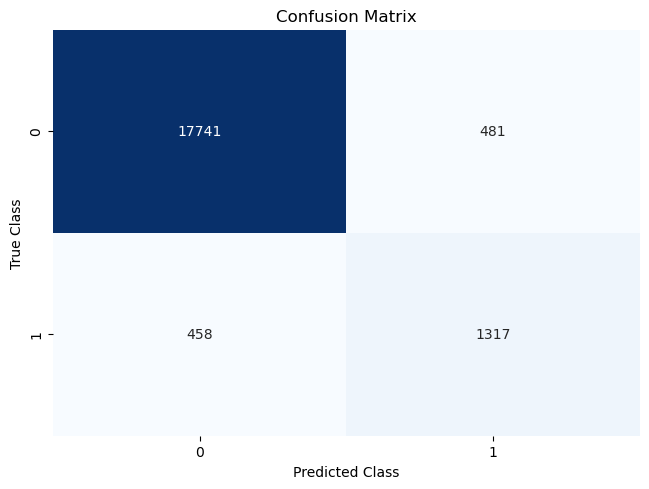

In [43]:
ypred = model(torch.tensor(X_test1).float()).detach().numpy()

ypred [ypred>=0.5] =1.0
ypred [ypred<0.5] =0.0

matrix = confusion_matrix(y_test, y_pred)

dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [44]:
print(metrics.classification_report(y_test1, ypred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     18222
           1       0.86      0.74      0.80      1775

    accuracy                           0.97     19997
   macro avg       0.92      0.86      0.89     19997
weighted avg       0.97      0.97      0.97     19997



As we can see here the deep learning model as performed significantly better than the logistic regression model and beats out the decision tree. The training time remains reasonable, unlike the decision tree module. It does help that it can be trained with 4 parallel treads which the decision tree code I wrote cannot. 

## Random forests

In [45]:
# calling the random forest

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [46]:
y_pred = rf.predict(X_test)
print(y_pred)

[0 0 0 ... 0 0 0]


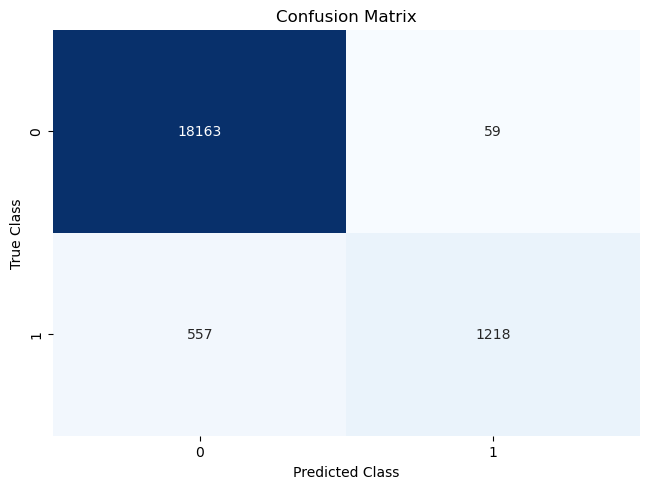

In [47]:
matrix = confusion_matrix(y_test, y_pred)

dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [48]:
print(metrics.classification_report(y_test1, ypred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     18222
           1       0.86      0.74      0.80      1775

    accuracy                           0.97     19997
   macro avg       0.92      0.86      0.89     19997
weighted avg       0.97      0.97      0.97     19997



# Excluding smoking history from the data.

To be sure that the interpolation step was the correct decision I will repeat the above analysis excluding smoking history from the data, I will use the same train test split to try and keep things consistent.

In [49]:
df2 = df.drop('smoking_history', axis= 1)

feature_set = df2.drop('diabetes', axis=1)
target_set = df2['diabetes']

In [50]:
# To do our train test split of the data.

X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set, test_size= 0.20, random_state= 42)


In [51]:
# This dictionary will be used later to label the confusion matrices

class_names = {0:'Diabetes', 1:'Not_Diabetes'}

In [52]:
# Notice here how I have increased the maximum number of iterations from the usual 100, given the number of features and the size of the dataset more than the standard is needed

logistic_regression_model = LogisticRegression(max_iter=1000)

logistic_regression_model.fit(X_train, y_train.values.ravel())

LogisticRegression(max_iter=1000)

In [53]:
# Running our test data through the model

predictions = logistic_regression_model.predict(X_test)

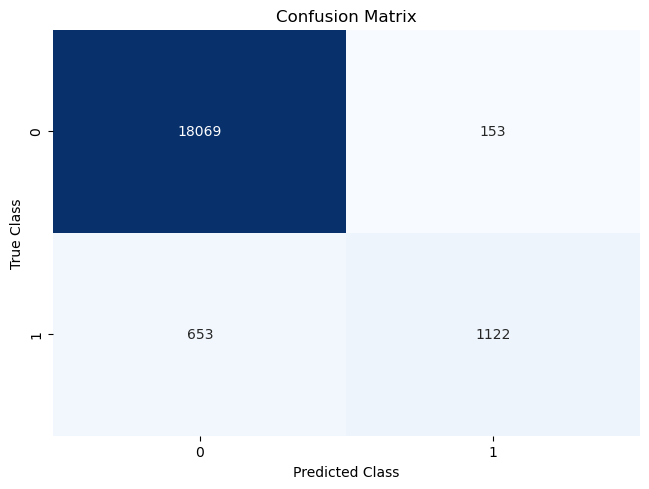

In [54]:
matrix = confusion_matrix(y_test, predictions)

dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [55]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18222
           1       0.88      0.63      0.74      1775

    accuracy                           0.96     19997
   macro avg       0.92      0.81      0.86     19997
weighted avg       0.96      0.96      0.96     19997



## Decision Tree 

In [56]:
# Calling the decision tree classifier from SK learn 

clf = DecisionTreeClassifier()

In [57]:
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

In [58]:
#Predict the response for test dataset
y_pred = clf.predict(X_test)

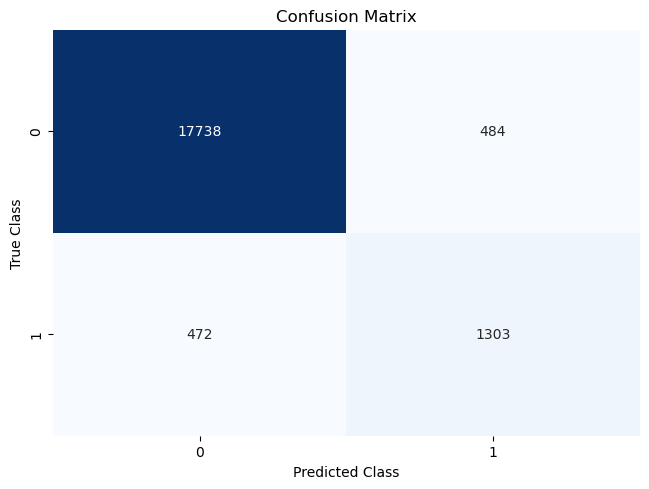

In [59]:
matrix = confusion_matrix(y_test, y_pred)

dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [60]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     18222
           1       0.73      0.73      0.73      1775

    accuracy                           0.95     19997
   macro avg       0.85      0.85      0.85     19997
weighted avg       0.95      0.95      0.95     19997



## Deep learning

In [61]:
# The first thing that we need to do is to scale the data so we don't end up with gradient explosion issues. 


# Original dataset
x = feature_set.values
y = target_set.values
scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.transform(x)
X_train1, X_test1, y_train1, y_test1 = train_test_split(x, y, test_size=0.2, random_state=42)

print('Sampled train dataset shape %s' % Counter(y_train1))
print('Sampled validation dataset shape %s' % Counter(y_test1))

Sampled train dataset shape Counter({0: 73260, 1: 6725})
Sampled validation dataset shape Counter({0: 18222, 1: 1775})


In [62]:
# time to bring it into pytorch and the torch dataloaders
batch_size = 512

numeber_of_cores = 0

training_dataset =  torch.utils.data.TensorDataset(torch.tensor(X_train1).float(), torch.tensor(y_train1).float())
test_dataset =      torch.utils.data.TensorDataset(torch.tensor(X_test1).float(), torch.tensor(y_test1).float())

train_dataloader = torch.utils.data.DataLoader(training_dataset,batch_size=batch_size, num_workers = numeber_of_cores)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, num_workers = numeber_of_cores)

In [63]:
# Creating the neural network class defining a two layer model that has ReLu layers between

class Classifier(torch.nn.Module):
    def __init__(self,n_input =10 , n_hidden = 15, n_output = 4, drop_prob = 0.5):
        super().__init__()
        # The first hidden layer
        self.extractor1 = torch.nn.Linear(n_input, n_hidden)
        # Second hidden layer
        self.extractor2 = torch.nn.Linear(n_hidden, n_hidden)
        # Third hidden layer
        self.extractor3 = torch.nn.Linear(n_hidden, n_hidden)
        # Relu non linear layer
        self.relu = torch.nn.ReLU()
        # A drop out for better learning
        self.dropout = torch.nn.Dropout(drop_prob)
        # The final layer that will pass out the classification
        self.classifier = torch.nn.Linear(n_hidden,n_output)
    # Forward pass of the data, taking it and   
    def forward(self, x_batch):
        x = self.relu(self.extractor1(x_batch))
        x = self.relu(self.extractor2(x))
        x = self.relu(self.extractor3(x))
        x = self.dropout(x)
        return self.classifier(x).squeeze()

In [64]:
def loss(model, loss_function, x_batch , y_batch, opt = None):
        # Using the loss function of choise to calculate the loss on each step
    loss = loss_function(model(x_batch),y_batch)
    # Just to make sure we arent going to throw and error if there isnt an actual optimiser to use.
    if opt is not None:
            loss.backward()
            opt.step()
            opt.zero_grad()
    return loss.item(), len(x_batch)

In [65]:
# Function to train the model using a loop over the epochs

def train(model, epochs, loss_function, opt, train_dl, test_dl):
    for epoch in range(epochs):
        # Making sure the model is in train mode
        model.train()
        # for each of the minibatches
        for x_batch, y_batch in train_dl:
            loss(model, loss_function,x_batch,y_batch,opt)
        # taking the model out of training mode and into testing mode so we can see wha the effect of the updated training is
        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss(model, loss_function, xb, yb) for xb, yb in test_dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # printing out the current loss, it also helps to know which epoch we are up to
        print(epoch, test_loss)

In [66]:
# Setting up the model parameters, first the number of input variables 

n_input = X_train1.shape[1]

# Setting the output so it predicts a single variable
n_output = 1

# settign the number of hidden layers
n_hidden = 30

model = Classifier(n_input=n_input,n_hidden=n_hidden,n_output=n_output,drop_prob=0.2)

lr = 0.001
    
pos_weight = torch.tensor([5])
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

n_epoch = 1000

In [67]:
train(model,n_epoch,loss_func,opt,train_dataloader,test_dataloader)
model.eval()

0 0.8587868323640632
1 0.8521340884059264
2 0.8487226110509308
3 0.8439314095993165
4 0.8376309461770561
5 0.8276379072362735
6 0.8115012188425611
7 0.7849980839110615
8 0.7405873408536705
9 0.6700260353283911
10 0.5776377970196935
11 0.49120898796581247
12 0.4292701340236741
13 0.38916890024572526
14 0.3639151893532645
15 0.3478991023575049
16 0.3381860823656801
17 0.33126689986586005
18 0.3270025519768632
19 0.32409953633183125
20 0.3215298074486554
21 0.31927539448371595
22 0.31747284259010194
23 0.3165503597744776
24 0.315548621678809
25 0.31454975474338004
26 0.31403221545794335
27 0.3136159990253154
28 0.31289665990932863
29 0.3125117896479142
30 0.31241938803096636
31 0.3120238627529969
32 0.3119522935391402
33 0.3119680896820936
34 0.3116880847810775
35 0.3114740356818589
36 0.3111802375947928
37 0.31082023006502063
38 0.31081414277859853
39 0.3106132232112134
40 0.3107068371419854
41 0.3107974289888
42 0.3109505322299409
43 0.3105936658861113
44 0.31081534007576017
45 0.310704

Classifier(
  (extractor1): Linear(in_features=7, out_features=30, bias=True)
  (extractor2): Linear(in_features=30, out_features=30, bias=True)
  (extractor3): Linear(in_features=30, out_features=30, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (classifier): Linear(in_features=30, out_features=1, bias=True)
)

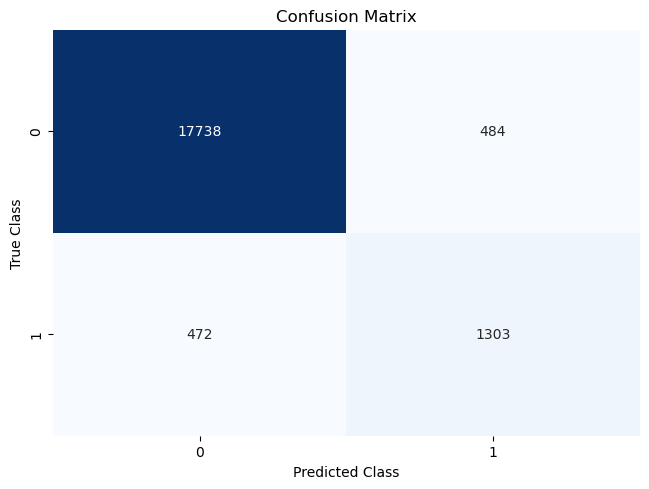

In [68]:
ypred = model(torch.tensor(X_test1).float()).detach().numpy()

ypred [ypred>=0.5] =1.0
ypred [ypred<0.5] =0.0

matrix = confusion_matrix(y_test, y_pred)

dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [69]:
print(metrics.classification_report(y_test1, ypred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     18222
           1       0.84      0.75      0.79      1775

    accuracy                           0.96     19997
   macro avg       0.91      0.87      0.89     19997
weighted avg       0.96      0.96      0.96     19997



## Random Forsests

In [70]:
# calling the random forest

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [71]:
y_pred = rf.predict(X_test)
print(y_pred)

[0 0 0 ... 0 0 0]


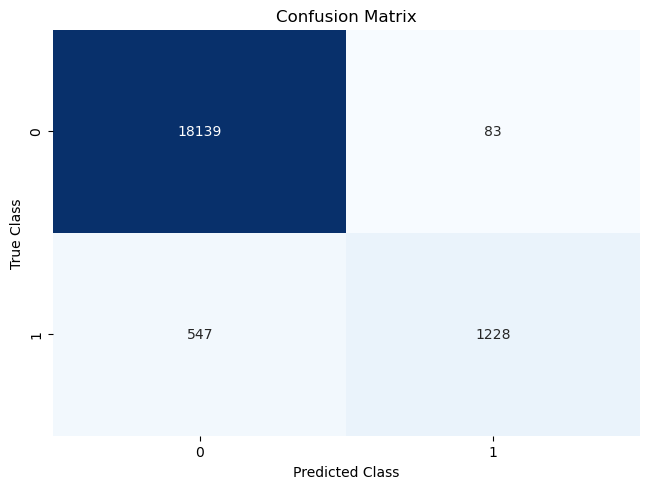

In [72]:
matrix = confusion_matrix(y_test, y_pred)

dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

In [73]:
print(metrics.classification_report(y_test1, ypred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     18222
           1       0.84      0.75      0.79      1775

    accuracy                           0.96     19997
   macro avg       0.91      0.87      0.89     19997
weighted avg       0.96      0.96      0.96     19997

